In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from iads.recommandation.prediction import get_cosine_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')

/Users/mathilde/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# I. Chargement des données :

In [2]:
df_jeux = pd.read_csv("../data/details_desc.csv")
df_jeux.head(2)

,categories,titre,description,full_title,Note Finkel,Note rectifiée,Nombre d'avis rectifiés,Note,Nombre d'avis,_id,...,editors,distributors,nb_players,age_required,duration,enfant,ado,adulte,solo,multi
0,NaN,Marvel United,marvel united unis contre super vilain red sku...,Marvel United (2020),8.74,8.40,10.0,7.58,19.0,marvel-united,...,CMON Limited,NaN,1-4,14-99,45.0,0,1,1,1,1
1,NaN,Mariposas,annee printemps million papillon monarque quit...,Mariposas (2020),7.68,7.29,17.0,7.39,33.0,mariposas,...,Gigamic,NaN,2-5,14-99,60.0,0,1,1,0,1


In [3]:
df_avis = pd.read_csv("../data/avis_clean.csv")
df_avis.head(2)

,comment,treated,date_published,title_review,author,note,title,title_id_jeu
0,"Lorsque le jeu est jeu, bon, réflexif, joli po...",True,2021,Voyages sur les ailes des papillons,Monsieur Guillaume,8.0,Mariposas,mariposas
1,Comment continuer après un mega hit ? Simpleme...,True,2020,le festival de Michoacan,morlockbob,7.0,Mariposas,mariposas


In [4]:
nb_desc_isna = len(df_jeux[df_jeux["description"].isna()])
nb_jeux = len(df_jeux)
print(nb_desc_isna, "descriptions manquantes sur", nb_jeux )
print(f"Soit {round((nb_desc_isna/nb_jeux)*100,3)}%")

1954 descriptions manquantes sur 16873
Soit 11.581%


In [5]:
df_jeux_nona = df_jeux.copy()
df_jeux_nona.fillna('', inplace=True)

# II. Descriptions

In [6]:
col_weights = {"'description'": 0.4,
            "'categories'":0.25,
            "['enfant','ado','adulte']":0.15,
            "['solo', 'multi']":0.15, #Récupérer le bon dataframe pour pouvoir ajouter "duo"
            "['creators', 'illustrators', 'editors', 'distributors']":0.05} 

similarity_matrices = []

for col, weight in tqdm(col_weights.items()):
    similarity_matrix = get_cosine_matrix(df_jeux_nona, eval(col))
    similarity_array = similarity_matrix.ravel()
    similarity_matrices.append(similarity_array * weight)

weighted_avg_matrix = np.sum(similarity_matrices, axis=0).reshape(similarity_matrix.shape)


100%|██████████| 5/5 [00:18<00:00,  3.75s/it]


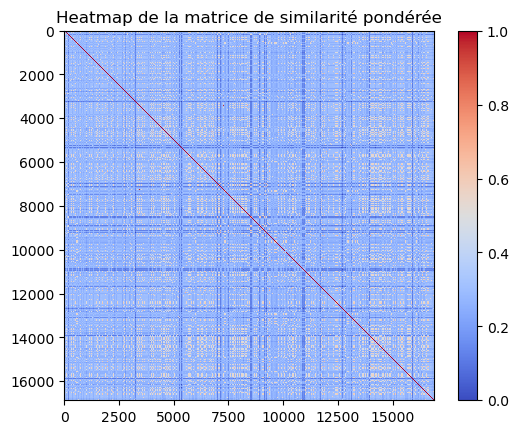

In [7]:
plt.imshow(weighted_avg_matrix, cmap='coolwarm', interpolation='nearest')
plt.title('Heatmap de la matrice de similarité pondérée')
plt.colorbar()
plt.show()

In [8]:
def graphe_knn(matrix):
    G = nx.Graph()
    k = 5 # Nombre de voisins à inclure dans le graphe

    for i in tqdm(range(matrix.shape[0])):
        # Extraire les indices des k voisins les plus proches pour chaque item
        neighbors = matrix[i].argsort()[-k-1:-1][::-1]
        
        for neighbor in neighbors:
            weight = matrix[i][neighbor]
            G.add_edge(i, neighbor, weight=weight)
    
    plt.figure(figsize=(5,5))
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=50)
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    #labels = {i: col for i, col in enumerate(df.index)}
    #nx.draw_networkx_labels(G, pos, labels)
    plt.axis('off')
    plt.show()


Rendu pas ouf du graphe donc pas obligé de le garder

# III. Recommandation

In [9]:
title="Mariposas"
idx = df_jeux_nona[df_jeux_nona['titre'] == title].index[0]

sim_scores = list(enumerate(weighted_avg_matrix[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

sim_scores = [i[0] for i in sim_scores if i[0] != idx][:10]

df_jeux_nona.iloc[sim_scores][['titre', 'description','categories']]

,titre,description,categories
9432,Papillons,papillon voler sens aligner guise papillon dep...,carte
16823,Mamma Mia ! Plus,saison,carte
14245,Elefun,elefun contenir bebe elepher soufflerie electr...,
2445,Keyflower : Storyteller,tuile printemps,
16308,Zoosim,tete zoo efforcer faire venir grand nombre vis...,plateau
3581,Myrmes,royaume myrme colonie fourmi lutter siecle dom...,placement
14703,Banque Fatale,but objectif augmenter valeur carte fatal vend...,plateau
6816,"Printemps, Été, Automne, Hiver",printemps ete automne hiver ensemble saison se...,
3575,Little observation,little observation observation jeune djeco ind...,plateau
7687,Cat & Fish,mettre place plateau tuile poisson munir cane ...,plateau
